# Meta-modeling tutorial

### Tanmoy Sanyal, Sali lab (tsanyal@salilab.org)

Hi everyone, and welcome to this brief tutorial that provides a demonstration of Sali-lab's current efforts in meta-modeling. In a nut-shell "meta-modeling" is the process of establishing a platform that can harmonize different computational models of the cell.

The focus of this tutorial is on a (hopefully!) hands-on demonstration of how this platform works, so for computational simplicity, the <em>cell models</em> used here are toy models. It is instructive that you do <strong>not</strong> go looking for biological meaning in the results shown below, but rather follow the computational aspect of how we can design platforms that enable information flow between different seemingly disparate simulation models.

The tutorial is divided into three sections with increasing complexity. To keep the material general enough, certain concepts and implementation have been intentionally coarse-grained out. Please feel free to interrupt and ask questions in between, or, for in-depth discussions, reach out to me later. 

## 1. Probabilistic graphical models (PGM) and probabilistic programming languages (PPL)

The framework that we'll eventually use to implement meta-modeling is a <strong>Probabilistic graphical models</strong>. These are graphical representations of complex joint probability distributions that enable efficient data storage and systematic protocols to understand the conditional inter-dependencies between different parts of the model (or for that matter different models, as we shall see in part-3). <strong>Probabilistic programming languages</strong> are frameworks built in well known (surprise, surprise) programming languages that enable fast Bayesian operations on such graphical models. In this tutorial, we'll use a well-known PPL called [PyMC3](https://docs.pymc.io), which is built on top of fast machine-learning libraries like [Theano](http://deeplearning.net/software/theano/) or [Tensorflow](https://www.tensorflow.org/). 

The central tenet of building simulation models, that is very close to all of our hearts (especially at Sali lab), is that all models are posterior densities that are amenable to the application of Bayes theorem:
<div> <img src="./content/bayes_theorem.png" width="500"> </div> 
    
where:

1. $M$ are the degrees of the freedom of the model: these could be anything, particle coordinates, chemical concentrations, time-varying or static).


2. $D$ is all available data. In fact, the ability to describe P given different sets of data D is Integrative Modeling as we know it today. But not all data may be available to all models, e.g. a pharmacokinetic (PK/PD) type of model deals with concentrations so presenting it with data on molecular co-ordinates would not make sense. <strong>That is where "meta-modeling" comes in! In meta-modeling, we try to couple not just all available data to a single model, but different models that may or may not have their own "appropriate" data.</strong>


3. $\theta$ denotes the parameters of the model, thus $P(M \mid \theta)$ is actually a probabilistic interpretation of the model equations (e.g. differential equations or many-body particle simulators etc.)


4. $P(\theta)$ is a probability distribution that reflects our prior belief on the parameters.

PGMs provide efficient and clear representations of posterior probabilitiy densities like $P(M \mid D, \theta)$. 
What does a PGM look like? To demonstrate this, let take the classical example of linear regression. Essentially we'll try to fit a line to some data, <em>but, in a Bayesian manner</em>.

First, we import some of the necessary python libraries:

In [1]:
%matplotlib inline

import os
import sys
import numpy as np
import copy
import matplotlib.pyplot as plt

Now, lets generate some fake data. Essentially generate points on a straight line and add some noise to them!

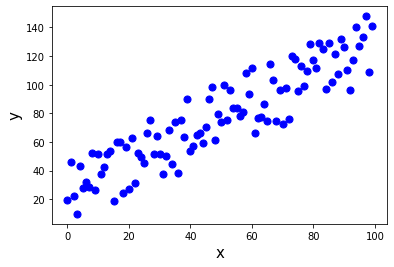

In [2]:
npoints = 100

target_m = 1.0 # slope
target_c = 2.0 # intercept

x = np.arange(npoints)
y = target_m * x + target_c
y_noised = y + 50*np.random.random(npoints)

plt.scatter(x, y_noised, c="blue", s=50)
plt.xlabel("x", fontsize=15)
plt.ylabel("y", fontsize=15)
plt.show()

### 1.1 Hierarchial linear Gaussian model
We can write a <em>hierarchical</em> linear gaussian model to explain the noisy data in the plot above.

$$m \sim \mathcal{N}(\mu_0, \sigma_0)$$ $$c \sim \mathcal{N}(\mu_1, \sigma_1)$$ $$y = mx+c$$ $$y_{noised} \sim \mathcal{N}(y, \sigma_2)$$

Essentially we are imposing our prior belief on the slope ($m$) and intercept ($c$) to be normally distributed. Then we represent our model as $y=mx+c$ and finally we propose that the observed data is also distributed normally around our model's calculated y values. (In this particular case, this is a strongly correct assumption since we already know that the data was generated from a straight line, but we may not be so lucky with more complex models). These specifications are <strong>nested</strong> within one another, hence the name <strong>hierarchial</strong>. The normal distributions we imposed on $m$ and $c$ are called <strong>priors</strong> while the parameters $\mu_0$, $\mu_1$ and $\sigma_0, \sigma_1, \sigma_2$ that characterize these distributions are called <strong>hyperpriors</strong>.

What does this model look like graphically? Lets begin by again importing a few libraries. Some of these are actually wrappers written over PyMC3 to facilitate working with probabilistic graphical models. And the tutorial_utils module is a bunch of functions to make life simpler for me while writing this tutorial (:P)

In [3]:
import pymc3 as pm # the PyMC3 package

sys.path.append("..")
from mm.core import jit # custom-wrapper for model compilation

import tutorial_utils as tu

Now lets define the model, basically write out the three equations above in PyMC3 specific syntax.

In [4]:
@jit
def linear_model(name="linear_model", inputs={}, evidence={}, start={}):
    mu_0 = 1.5
    sigma_0 = 0.1
    m = pm.Normal("m", mu=mu_0, sigma=sigma_0)
    
    mu_1 = 2.5
    sigma_1 = 0.1
    c = pm.Normal("c", mu=mu_1, sigma=sigma_1)
    
    x = inputs["x"]
    y = pm.Deterministic("y", m*x + c)
    
    sigma_2 = 10
    y_noised = pm.Normal("y_noised", mu=y, sigma=sigma_2, shape=len(x))

That's all there is to it! We defined a function that creates a model called "linear model" and adds the variables ```m, c, y``` and ```y_noised``` to it (note that it doesn't need to return anything). Lets' visualize the graphical model that PyMC3 created! The PGM here is rendered in what is known as "plate" notation. The rectange surrounding ```y_noised``` is called a <strong>plate</strong> and it is implied to be repeated (along with all incoming and outgoing edges) for the number of times (in this case the number of datapoints = 100) written at the bottom right corner of the plate.

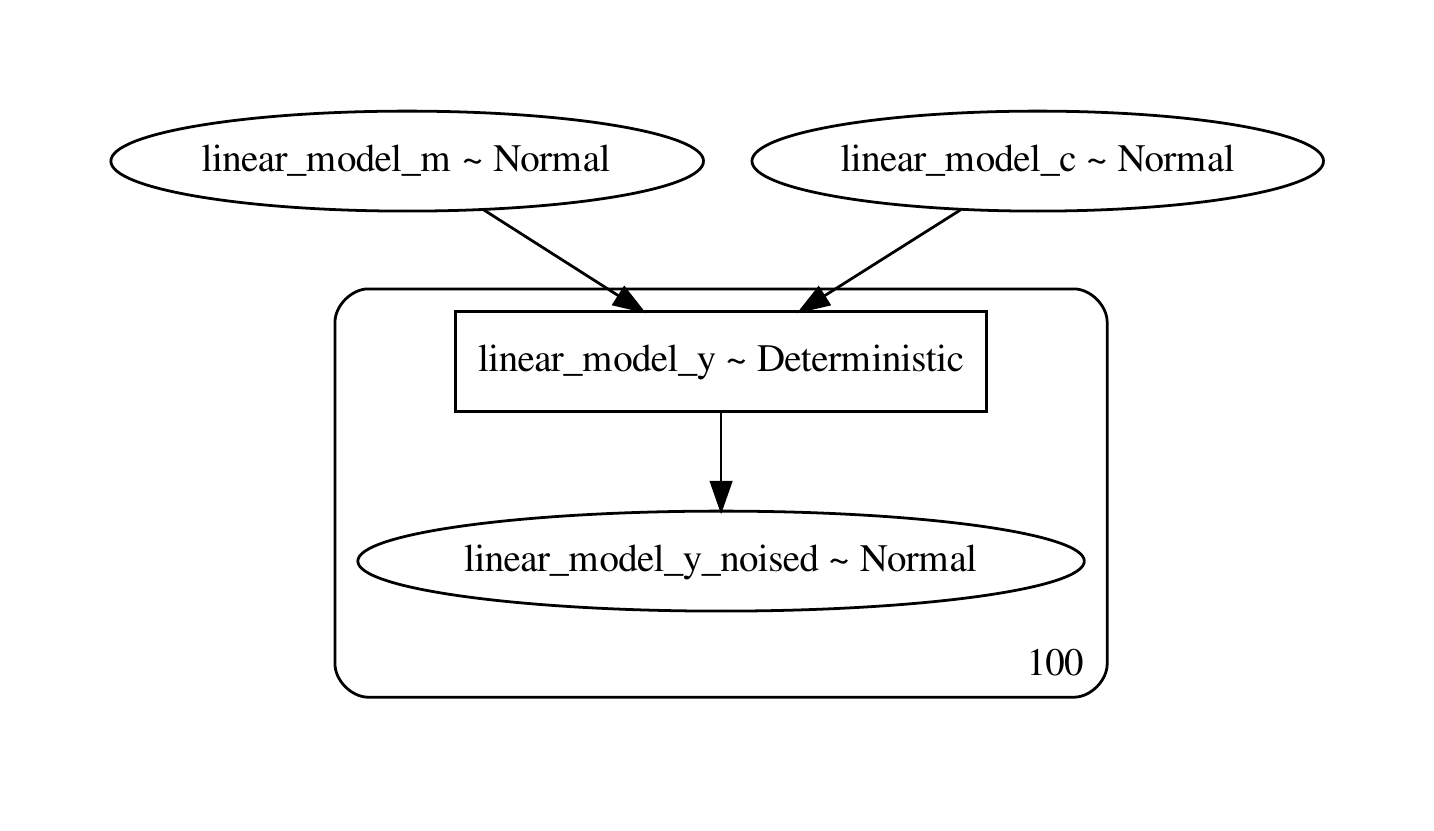

In [5]:
m1=linear_model(name="linear_model", inputs={"x":x}, evidence={}, start={})
tu.visualize_model(m1, h=500, w=500)

### 1.2 Important terminology
These terms will be helpful later on. For the sake of generality, I'll keep these descriptions short. You are encouraged to discuss / reach out later, if you have questions.

1. <strong>```@jit```</strong> This is a decorator that sits on top of the model builder function (```linear_model()```) and it delayes the <strong>I-E-S</strong> (input, evidence, start) specification to the model till compile time. Fun fact, it also appends the name of the model to the name of the nodes, so that ```m``` becomes ```linear_model_m```, etc. Hence the name "jit" which stands for "just-in-time" compilation.


2. <strong>```inputs```</strong>: This is a dictionary of variables that are supplied to the model to be used as is. In this case, it was the array of independent variables x. Note that for this problem, the input ```x``` is <em>not</em> assigned a node in the PGM, because it is not a random variable. But in general inputs can be other random variables, even belonging to other models and in fact, this construct presents the principle point of entry of information from one model to another when doing meta-modeling.


3. <strong>```evidence```</strong>: evidence represents the data that we use to train our model. In this case, it will be the noisy values of y generated before (the blue scattered dots). For reasons of numerical stability that I'll not mention here, it is recommended that <strong>you do not provide evidence to nodes that are roots</strong>, i.e. nodes like ```m``` and ```c```, that don't have parents. Only provide evidence to nodes like ```y_noised``` that have parents.


4. <strong>```start```</strong> : start contains starting points (```t=0``` values) of variables that are dynamic i.e. timeseries. All variables for this simple model are static so start is empty.

### 1.3 Bayesian inference in action
After providing evidence to a model we can <strong>train</strong> it to update the prior distributions to more refined values representing the uncertainty of the data. For training, we use something called <strong>variational inference</strong> which, in a nutshell, is an approximate form of sampling the posterior distributions $P(m \mid y_{noised}$) and $P(c \mid y_{noised}$). Lets create another model instance, this time providing evidence. Note that while providing evidence, you must use the final full name of the variable in the compiled model (i.e. add the name of the model, "linear_model" before it)


Building linear model...


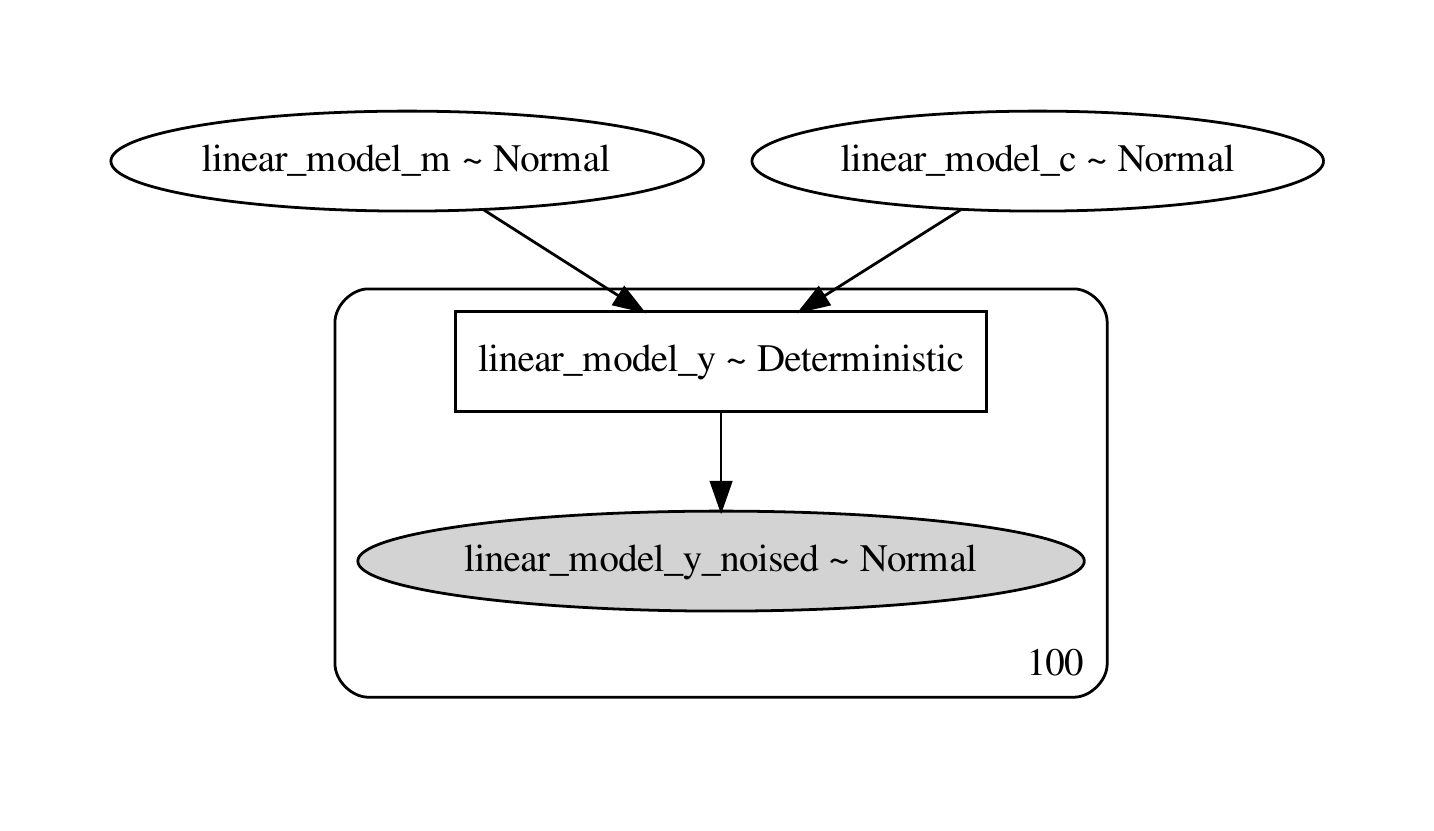



Training on noisy y data...


Average Loss = 493.43: 100%|██████████| 20000/20000 [00:05<00:00, 3819.85it/s]
Finished [100%]: Average Loss = 493.42




Converting all samples to histograms..

Validating by recalculating y = mx+c...


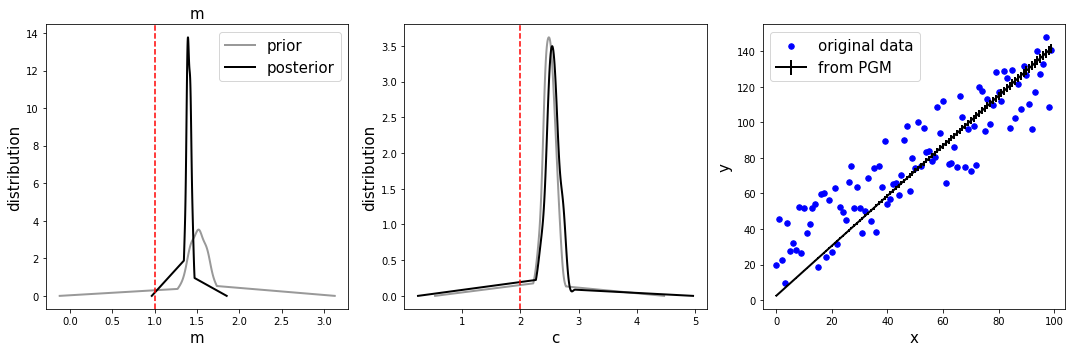

In [6]:
# build the model with evidence
print("\nBuilding linear model...")
m2 = linear_model(name="linear_model", inputs={"x": x}, evidence={"linear_model_y_noised": y_noised})

# visualize the modelo
tu.visualize_model(m2, h=600, w=600)

# number of samples
ns = 100

# before the distributions for m and c can get updated due to training, collect their priors
# this will be useful for plotting later
print("\nCollecting prior samples of m and c...")
m_pri_samples = tu.get_prior_samples(m2, "linear_model_m", samples=ns)
c_pri_samples = tu.get_prior_samples(m2, "linear_model_c", samples=ns)

# train the model (i.e. sample from the posterior distributions of m and c given y_noise)
# this returns a "trace" which is a dictionary containing samples from the posterior distributions
print("\nTraining on noisy y data...")
_, trace = tu.sample_posterior(m2, tune=20000, samples=ns)

# collect posterior samples
print("\nCollecting posterior samples of m and c...")
m_post_samples = trace["linear_model_m"]
c_post_samples = trace["linear_model_c"]

# convert samples to distributions
print("\nConverting all samples to histograms..")
m_pri = tu.get_distribution(m_pri_samples, vartype="static", smooth=True)
c_pri = tu.get_distribution(c_pri_samples, vartype="static", smooth=True)

m_post = tu.get_distribution(m_post_samples, vartype="static", smooth=True)
c_post = tu.get_distribution(c_post_samples, vartype="static", smooth=True)

# validation: re-calculate new noisy values of y this time from the PGM!
print("\nValidating by recalculating y = mx+c...")
y_new_samples = np.array([m_post_samples[i]*x + c_post_samples[i] for i in range(ns)])
y_new, y_new_err = tu.get_distribution(y_new_samples, vartype="dynamic")

# plot prior vs posterior
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,3,1)
ax1.set_title("m", fontsize=15)
ax1.set_xlabel("m", fontsize=15)
ax1.set_ylabel("distribution", fontsize=15)
ax1.plot(m_pri[0], m_pri[1], "k-", lw=2, alpha=0.4, label="prior")
ax1.plot(m_post[0], m_post[1], "k-", lw=2, label="posterior")
ax1.axvline(target_m, color="r", ls="--", lw=1.5)
ax1.legend(prop={"size": 15})

ax2 = fig.add_subplot(1,3,2)
ax2.set_xlabel("c", fontsize=15)
ax2.set_ylabel("distribution", fontsize=15)
ax2.plot(c_pri[0], c_pri[1], "k-", alpha=0.4, lw=2)
ax2.plot(c_post[0], c_post[1], "k-", lw=2)
ax2.axvline(target_c, color="r", ls="--", lw=1.5)

ax3 = fig.add_subplot(1,3,3)
ax3.set_xlabel("x", fontsize=15)
ax3.set_ylabel("y", fontsize=15)
ax3.scatter(x, y_noised, s=30, c="blue", label="original data")
ax3.errorbar(x, y_new, yerr=y_new_err, color="black", lw=2, label="from PGM")
ax3.legend(prop={"size": 15})

fig.tight_layout()
plt.show()


Note that evidence in the PGM is indicated by shading a node. After this experiment, we see that we have been able to update our belief from the prior distributions of $m$ and $c$ to their posterior. Although the posterior means are still off from the true target values (indicated by dotted lines), the posteriors definitely capture the uncertainty of the training data presented to them. This can be seen from:

1. The posterior of $m$ being much narrower, so that now we have more confidence in its estimate.


2. Recalculating $y$ from the PGM (the black line in the third plot) produces a very good fit with very low uncertainty.(the errorbars are barely visible)

Could we have done better to capture the targets? The answer is yes, and it requires sampling the posterior using more accurate methods than the simple approximate variational inference we use here. But such methods are computationally intensive and are best left out of an interactive tutorial like this. Please feel free to reach out if you would like to learn more.

### 1.4 Summary

The key take away messages from this section are:

1. Probabilistic graphical models help us visualize and perform posterior estimation for probability distributions over several variables.


2. Probabilistic programming languages like PyMC3 offer a very user-friendly implementation of Bayesian inference problems in such graphical models.


3. Estimating posteriors given data (evidence) may help reduce uncertainty in the prior estimates of model parameters. As we shall see in the next section, this statement carries over to meta-modeling too. 

## 2. Meta-modeling 101: How do you couple different models (PGMs) ?

Now that you have seen that a model (in principle any simulation model) can be converted to a PGM, lets see how to do meta-modeling by coupling two PGMs. Imagine you are studying the effect of a new drug on cancer cell growth. To make life simpler, lets focus on one particular tumor cell. You treated it with this magic drug and it did show some progress. Load the daily cell volume measurement (done over a period of 29 days) (kept in ```datasets/tumor_vol.dat```)

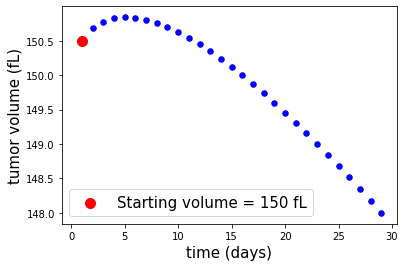

In [7]:
# extract data
voldata = np.loadtxt("./datasets/tumor_vol.dat")
tdata = voldata[:,0]
vdata = voldata[:,1]

# target values of variables used in this section
k1_target = 1.0
k2_target = 2.0
n_target = 0.75

# get starting cell volume 
v0 = vdata[0]

# plot
plt.scatter(tdata, vdata
, s=30, c="blue")
plt.scatter(tdata[0], v0, s=100, c="red", label="Starting volume = 150 fL")
plt.xlabel("time (days)", fontsize=15)
plt.ylabel("tumor volume (fL)", fontsize=15)
plt.legend(prop={"size": 15})
plt.show()

### 2.1 The Treatment model

As the simplest possible model of the treatment, you assume that the tumor volume reduces linearly everyday according to $$v(t) = v_0 - k_1t$$ where $v_0$ is the starting volume of the tumor (~150 fL) and $k_1$ is the steady reduction rate. $k_1$ thus is a metric of the efficiency of this treatment and based on your prior experiences with tumor cells of this type (and also because you are a seasoned researcher :)), you have strong reason to believe that $k_1 \approx 0.8$. Lets build a PGM for this simple treatment model and provide it with the volume data (above) as evidence.

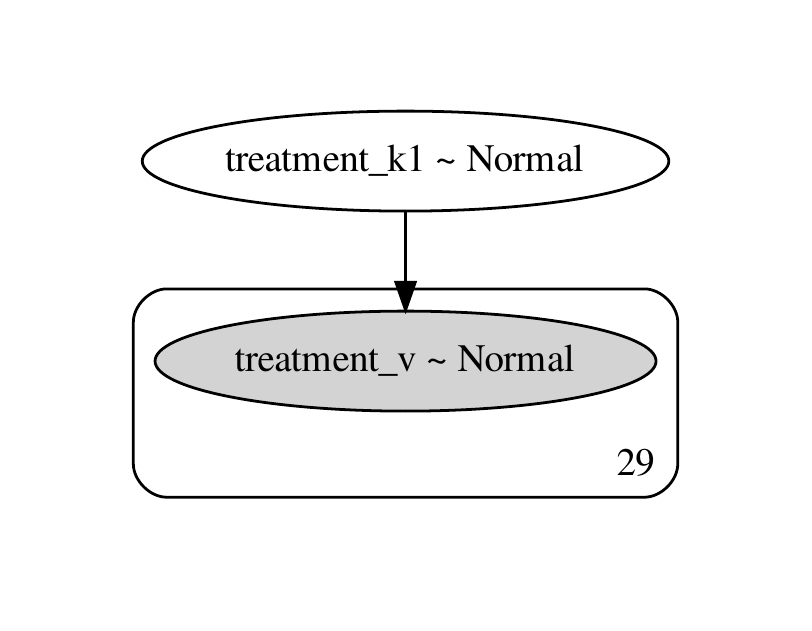

In [8]:
@jit
def TreatmentModel(name="treatment", inputs={}, evidence={}, start={}):
    t = inputs["t"]
    v0 = inputs["v0"]
    k1 = pm.Normal("k1", mu=0.8, sigma=1.0)
    v = pm.Normal("v", mu=v0-k1*t, sigma=1.0, shape=len(t))
    
m1 = TreatmentModel(name="treatment", inputs={"t": tdata, "v0": v0}, evidence={"treatment_v": vdata})
tu.visualize_model(m1)

Now, lets train this model and see how good it is in explaining the volume profile that was measured.


Training Treatment model...


Average Loss = 35.326: 100%|██████████| 50000/50000 [00:12<00:00, 4060.69it/s]
Finished [100%]: Average Loss = 35.326


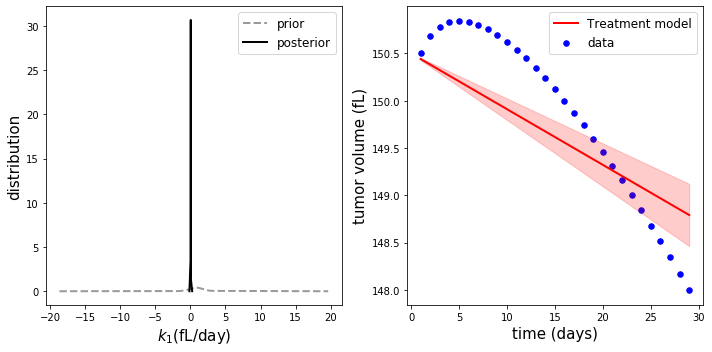

In [9]:
# collect prior samples
k1_pri_samples = tu.get_prior_samples(m1, "treatment_k1", samples=ns)

# train the model
print("\nTraining Treatment model...")
_, trace = tu.sample_posterior(m1, tune=50000, samples=ns)

# collect posterior samples
k1_post_samples = trace["treatment_k1"]
v_post_samples = np.array([v0-k1_post_samples[i]*tdata for i in range(ns)])

# convert all samples to histograms
k1_pri = tu.get_distribution(k1_pri_samples, vartype="static", smooth=True)
k1_post = tu.get_distribution(k1_post_samples, vartype="static", smooth=True)
v_post, v_post_err = tu.get_distribution(v_post_samples, vartype="dynamic")

# plot
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r"$k_1 \mathrm{ (fL/day)}$", fontsize=15)
ax1.set_ylabel("distribution", fontsize=15)
ax1.plot(k1_pri[0], k1_pri[1], "k-", lw=2, ls="--", alpha=0.4, label="prior")
ax1.plot(k1_post[0], k1_post[1], "k-", lw=2, label="posterior")

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel("time (days)", fontsize=15)
ax2.set_ylabel("tumor volume (fL)", fontsize=15)
ax2.scatter(tdata, vdata, s=30, c="blue", label="data")
ax2.plot(tdata, v_post, "r-", lw=2, label="Treatment model")
ax2.fill_between(tdata, v_post-v_post_err, v_post+v_post_err, color="r", alpha=0.2)

ax1.legend(prop={"size": 12})
ax2.legend(prop={"size": 12})
fig.tight_layout()
plt.show()

And, it doesn't really do a good job. Because the model was given data to train, it does end up adjusting the posterior probability of $k_1$ and narrowing the spread, but this estimate predicts a sharply linear volume reduction and does not explain why the tumor was still growing till day 6 or so.

This is where your skeptical colleague enters the scene, who has been (unbeknown to you) working on the same problem for sometime. Also, they are a little like this guy:
<div><img src=./content/house.jpg width=400></div>
<br></br>
They are harshly critical of your simple approach and suggest that the most obvious thing you have missed is that the tumor has an internal growth mechanism and is growing all the time throughout the treatment.

### 2.2 The Growth model

For the sake of this tutorial, assume that your co-worker is really arrogant (the picture above may help) and insists that the internal growth dynamics of the tumor actually overwhelm your therapy and these dynamics are complex enough to explain both the initial increase and subsequent reduction in volume. They even provide a non-linear model for the growth $$v(t)=v_0 + k_2t^n$$ where $k_2$ (fL/day) is the steady growth rate and the exponent $n$ is dimensionless.

At this point, you are (a) frustrated by your own therapy model failing, (b) somewhat browbeat by your coworker and (c) starting to see how their model may be correct since the data is obviously non-linear and they are proposing a non-linear model. So, you give it a shot and build a PGM for the growth model, giving it the same tumor volume profile as evidence. But, being the astute scientist that you are, you leave a little leeway for your own prior belief that the phenomena still might be linear by using a prior value of $n \approx 0$. 

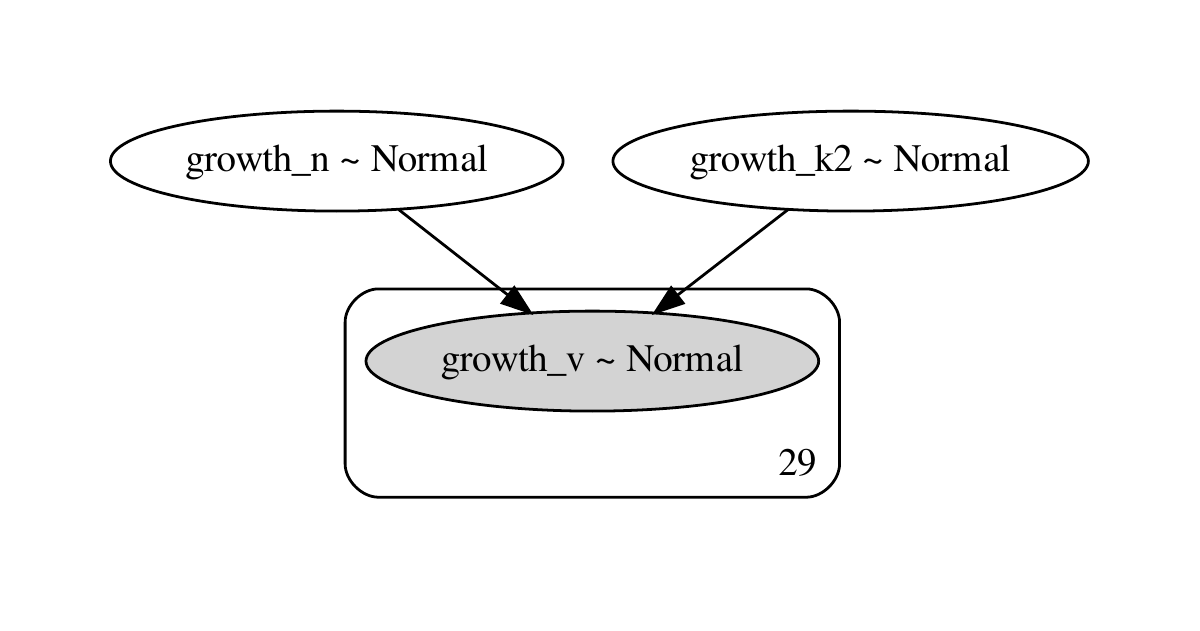

In [10]:
@jit
def GrowthModel(name="growth", inputs={}, evidence={}, start={}):
    t = inputs["t"]
    v0 = inputs["v0"]
    k2 = pm.Normal("k2", mu=1.5, sigma=0.1)
    n = pm.Normal("n", mu=0.0, sigma=0.1)
    v = pm.Normal("v", mu=v0+k2*t**n, sigma=0.1, shape=len(t))

m2 = GrowthModel(name="growth", inputs={"t":tdata, "v0": v0}, evidence={"growth_v": vdata})
tu.visualize_model(m2, h=600, w=600)

Same routine again, train the growth model and check if it makes sense.


Training Growth model...


Average Loss = 1,891.6: 100%|██████████| 50000/50000 [00:13<00:00, 3684.65it/s]  
Finished [100%]: Average Loss = 1,891.6


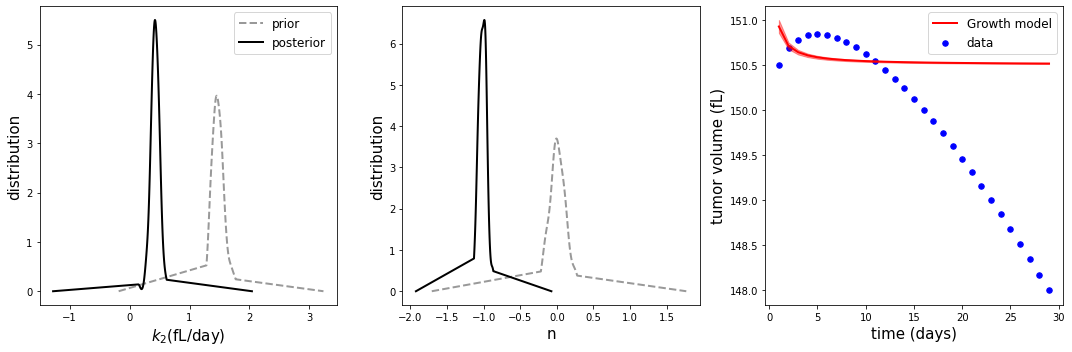

In [11]:
# collect prior samples
k2_pri_samples = tu.get_prior_samples(m2, "growth_k2", samples=ns)
n_pri_samples = tu.get_prior_samples(m2, "growth_n", samples=ns)

# train the model
print("\nTraining Growth model...")
_, trace = tu.sample_posterior(m2, tune=50000, samples=ns)

# collect posterior samples
n_post_samples = trace["growth_n"]
k2_post_samples = trace["growth_k2"]
v_post_samples = np.array([v0+k2_post_samples[i]*tdata**n_post_samples[i] for i in range(ns)])

# convert all samples to histograms
k2_pri = tu.get_distribution(k2_pri_samples, vartype="static", smooth=True)
n_pri = tu.get_distribution(n_pri_samples, vartype="static", smooth=True)
k2_post = tu.get_distribution(k2_post_samples, vartype="static", smooth=True)
n_post = tu.get_distribution(n_post_samples, vartype="static", smooth=True)
v_post, v_post_err = tu.get_distribution(v_post_samples, vartype="dynamic")

# plot
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax1.set_xlabel("$k_2 \mathrm{ (fL/day)}$", fontsize=15)
ax1.set_ylabel("distribution", fontsize=15)
ax1.plot(k2_pri[0], k2_pri[1], "k-", lw=2, ls="--", alpha=0.4, label="prior")
ax1.plot(k2_post[0], k2_post[1], "k-", lw=2, label="posterior")

ax2 = fig.add_subplot(1,3,2)
ax2.set_xlabel("n", fontsize=15)
ax2.set_ylabel("distribution", fontsize=15)
ax2.plot(n_pri[0], n_pri[1], "k-", lw=2, ls="--", alpha=0.4)
ax2.plot(n_post[0], n_post[1], "k-", lw=2)

ax3 = fig.add_subplot(1,3,3)
ax3.set_xlabel("time (days)", fontsize=15)
ax3.set_ylabel("tumor volume (fL)", fontsize=15)
ax3.scatter(tdata, vdata, s=30, c="blue", label="data")
ax3.plot(tdata, v_post, "r-", lw=2, label="Growth model")
ax3.fill_between(tdata, v_post-v_post_err, v_post+v_post_err, color="r",
                 alpha=0.4)

ax1.legend(prop={"size": 12})
ax3.legend(prop={"size": 12})
fig.tight_layout()
plt.show()

Oops! The treatment model was still predicting a steady reduction, this guy just says that growth stops on its own after day 3 or so. You can see why this happened. The Bayesian estimate of $n$ (in the middle plot) is ~ -1.0. So, your colleague wasn't right either. In a real world scenario, if you fit either of these models to your data and then sent the parameters to a wet-lab that wanted to use your treatment (Treatment Model) or exploit the tumor's internal growth process (Growth Model) to do animal testing, you'd have the blood (sic) of a lot of rats on your head by now.

At this point, you thank yourself that you came to this retreat and attended this tutorial and move on to how you can use these two existing models to come up with a better model.

### 2.3 The "meta-model"

Instead of throwing away both models and breaking our heads on how to come up with yet another one, lets see if we can combine these to form a model that is informed by the beliefs of both you and your co-worker.

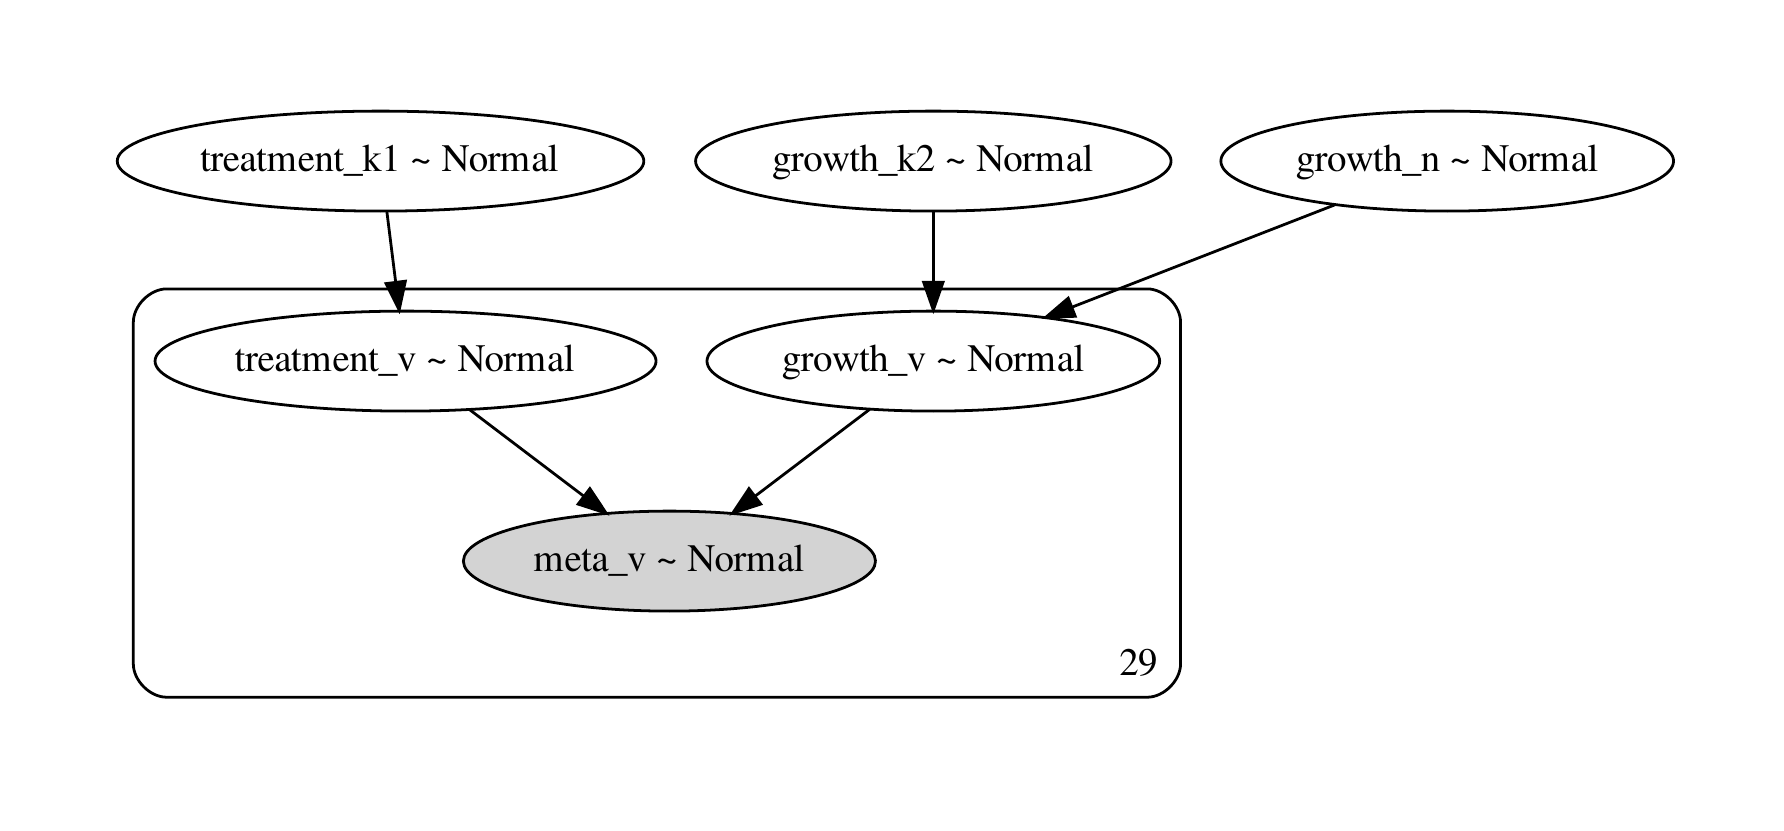

In [12]:
@jit
def MetaModel(name="meta", inputs={}, evidence={}, start={}):
    t = inputs["t"]
    v0 = inputs["v0"]
    # invoke the treatment model
    treatment = TreatmentModel(name="treatment", inputs=inputs, evidence=evidence, start=start)
    # invoke the growth model
    growth = GrowthModel(name="growth", inputs=inputs, evidence=evidence, start=start)
    # combine (average) the tumor volume predictions from both models
    v = pm.Normal("v", mu=0.5*(treatment.v + growth.v), sigma=0.1, shape=len(t))
    
mm = MetaModel(name="meta", inputs={"t":tdata, "v0": v0}, evidence={"meta_v": vdata})
tu.visualize_model(mm, h=800, w=800)

See what we did here, we <strong>combined</strong> the ```v``` node, i.e. the tumor volume prediction from both the treatment and growth models into a single node we call ```meta_v```. This combination could be any mathematical function in principle, here we go with the simplest possible expression: ```meta_v = (growth_v + treatment_v)/2```. The <strong>new edges</strong> that were added to both the models, connecting them to ```meta_v``` form what are called <strong>active trails</strong>. Active trails <strong>theoretically guarantee</strong> flow of information between the two models, e.g. information can now flow from the ```growth_n``` and ```growth_k2``` nodes to the ```treament_k1``` node and vice versa.

Lets train this model with the tumor volume data and see if its any good. 


Training meta-model...


Average Loss = 35.437: 100%|██████████| 50000/50000 [00:16<00:00, 3065.71it/s]   
Finished [100%]: Average Loss = 35.415



Avg. uncertainty (std. dev / mean) of tumor volume prediction = 0.08 %


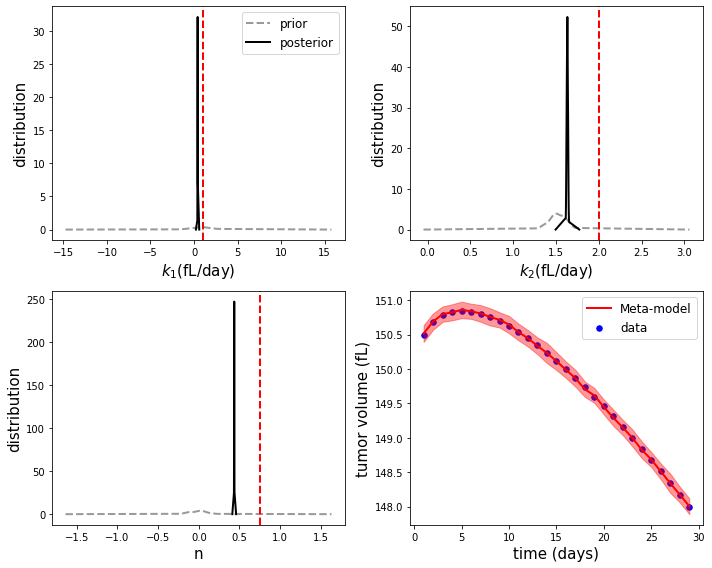

In [13]:
# collect prior samples
k1_pri_samples = tu.get_prior_samples(mm, "treatment_k1", samples=ns)
k2_pri_samples = tu.get_prior_samples(mm, "growth_k2", samples=ns)
n_pri_samples = tu.get_prior_samples(mm, "growth_n", samples=ns)

# train the model
print("\nTraining meta-model...")
_, trace = tu.sample_posterior(mm, tune=50000, samples=ns)

# collect posterior samples
k1_post_samples = trace["treatment_k1"]
k2_post_samples = trace["growth_k2"]
n_post_samples = trace["growth_n"]
v_post_samples = 0.5*(trace["growth_v"] + trace["treatment_v"])

# convert all samples to distributions 
k1_pri = tu.get_distribution(k1_pri_samples, vartype="static", smooth=True)
k2_pri = tu.get_distribution(k2_pri_samples, vartype="static", smooth=True)
n_pri = tu.get_distribution(n_pri_samples, vartype="static", smooth=True)
k1_post = tu.get_distribution(k1_post_samples, vartype="static", smooth=True)
k2_post = tu.get_distribution(k2_post_samples, vartype="static", smooth=True)
n_post = tu.get_distribution(n_post_samples, vartype="static", smooth=True)
v_post, v_post_err = tu.get_distribution(v_post_samples, vartype="dynamic")
stderr = 100. * np.mean(v_post_err/v_post)
print("\nAvg. uncertainty (std. dev / mean) of tumor volume prediction = %2.2f %%" % stderr)

# plot

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,2,1)
ax1.set_xlabel("$k_1 \mathrm{ (fL/day)}$", fontsize=15)
ax1.set_ylabel("distribution", fontsize=15)
ax1.plot(k1_pri[0], k1_pri[1], "k-", lw=2, ls="--", alpha=0.4, label="prior")
ax1.plot(k1_post[0], k1_post[1], "k-", lw=2, label="posterior")
ax1.axvline(k1_target, color="r", ls="--", lw=2)
ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel("$k_2 \mathrm{ (fL/day)}$", fontsize=15)
ax2.set_ylabel("distribution", fontsize=15)
ax2.plot(k2_pri[0], k2_pri[1], "k-", lw=2, ls="--", alpha=0.4)
ax2.plot(k2_post[0], k2_post[1], "k-", lw=2)
ax2.axvline(k2_target, color="r", ls="--", lw=2)

ax3 = fig.add_subplot(2,2,3)
ax3.set_xlabel("n", fontsize=15)
ax3.set_ylabel("distribution", fontsize=15)
ax3.plot(n_pri[0], n_pri[1], "k-", lw=2, ls="--", alpha=0.4)
ax3.plot(n_post[0], n_post[1], "k-", lw=2)
ax3.axvline(n_target, color="r", ls="--", lw=2)

ax4 = fig.add_subplot(2,2,4)
ax4.set_xlabel("time (days)", fontsize=15)
ax4.set_ylabel("tumor volume (fL)", fontsize=15)
ax4.scatter(tdata, vdata, s=30, c="blue", label="data")
ax4.plot(tdata, v_post, "r-", lw=2, label="Meta-model")
ax4.fill_between(tdata, v_post-v_post_err, v_post+v_post_err, color="r", alpha=0.4)

ax1.legend(prop={"size": 12})
ax4.legend(prop={"size": 12})
fig.tight_layout()
plt.show()

Voila! We finally have estimates of $k_1$, $k_2$ and $n$ that can explain the initial growth and subsequent decay of the tumor volume data without resorting to any other external information or model. The target values of $k_1$, $k_2$ and $n$ used to generate the tumor data are shown in red dotted lines, and although we didn't recapture their exact values, the estimates we got are sufficient to explain the tumor volume data with less than 1% uncertainty.

Notice that the estimate of $k_1$ is not too different from its prior estimate while those for $k_2$ and $n$ are. That means the size reduction due to treatment actually dominates the over-all volume profile and growth dynamics only account for the initial growth period. So while neither you or your co-worker was a 100% accurate, pooling both your knowledge through a rigorous probabilistic framework, helped bring out the best result.

### 2.4 Summary

In this section, you learned that:

1. Probabilistic graph representations of different input models can be combined cleverly to ensure information flow between nodes in the different graphs.


2. Such information flow increases the explanatory power of the combined model.


3. The framework is modular, i.e. models may be partially or completely agonistic of each other. E.g., in this example the treatment model knew nothing about the cell's internal dynamics and the growth model had no idea that an external drug had been administered. Meta-modeling provides the statistical "glue" that enable partially informed models to still talk to each other.

## 3. Building a simple meta-model for beta-cell biology

Now that you know how to build meta-models, let us take a slightly less contrived example from beta cell biology. So far, you have already seen how a probabilistic model is built through the ```@jit``` constructor and a model builder function. Here, we have made the task easier for you so that you can just import pre-built models. For this section, we'll consider only two models: the <strong>meal model</strong> and the <strong>spt model</strong>. Fair warning though, the model PGMs won't look pretty, because of the large number of nodes.


Meal Model


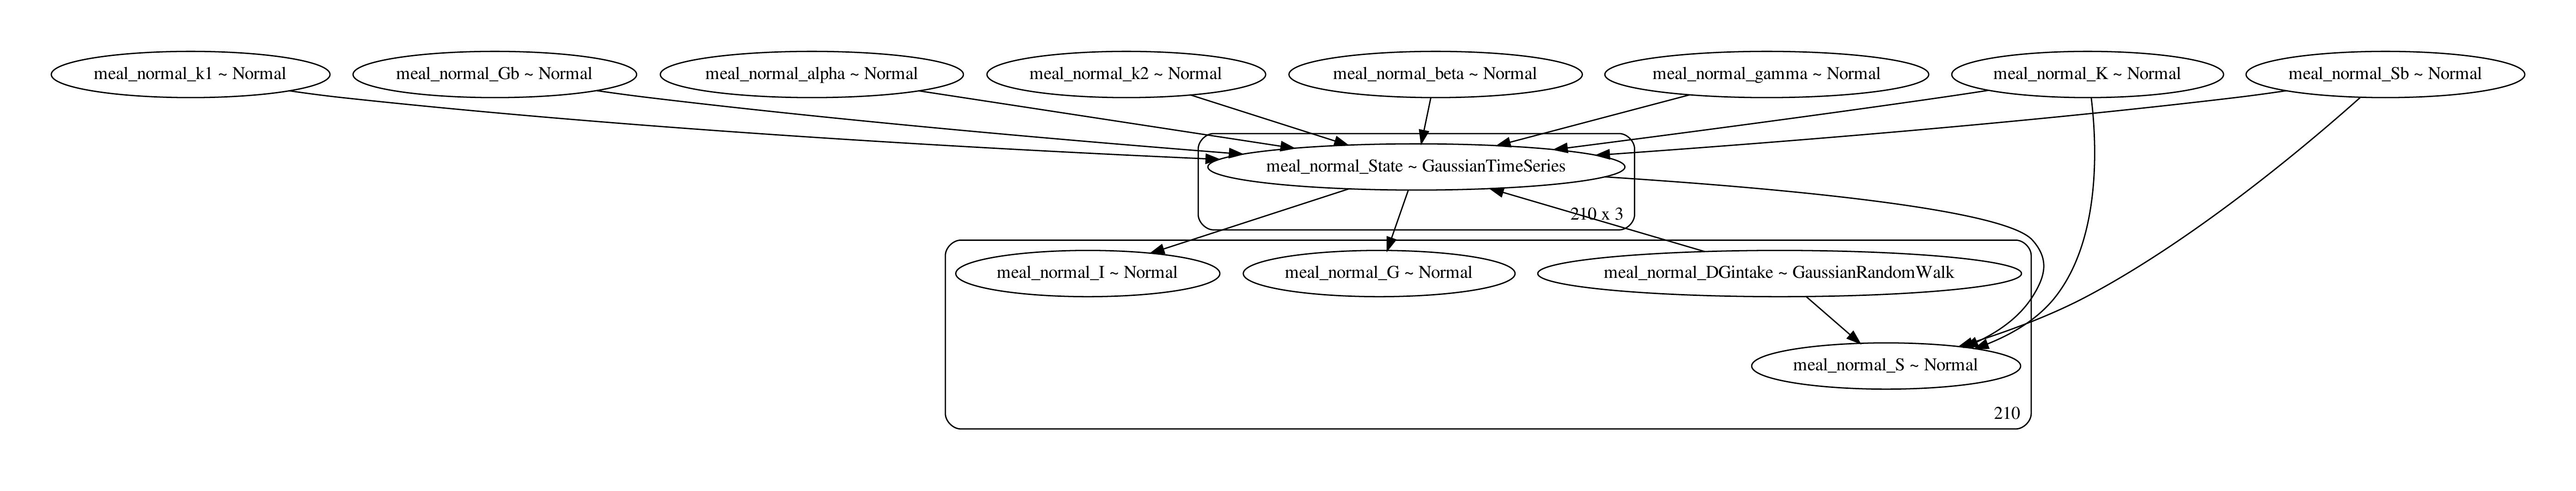


SPT Model


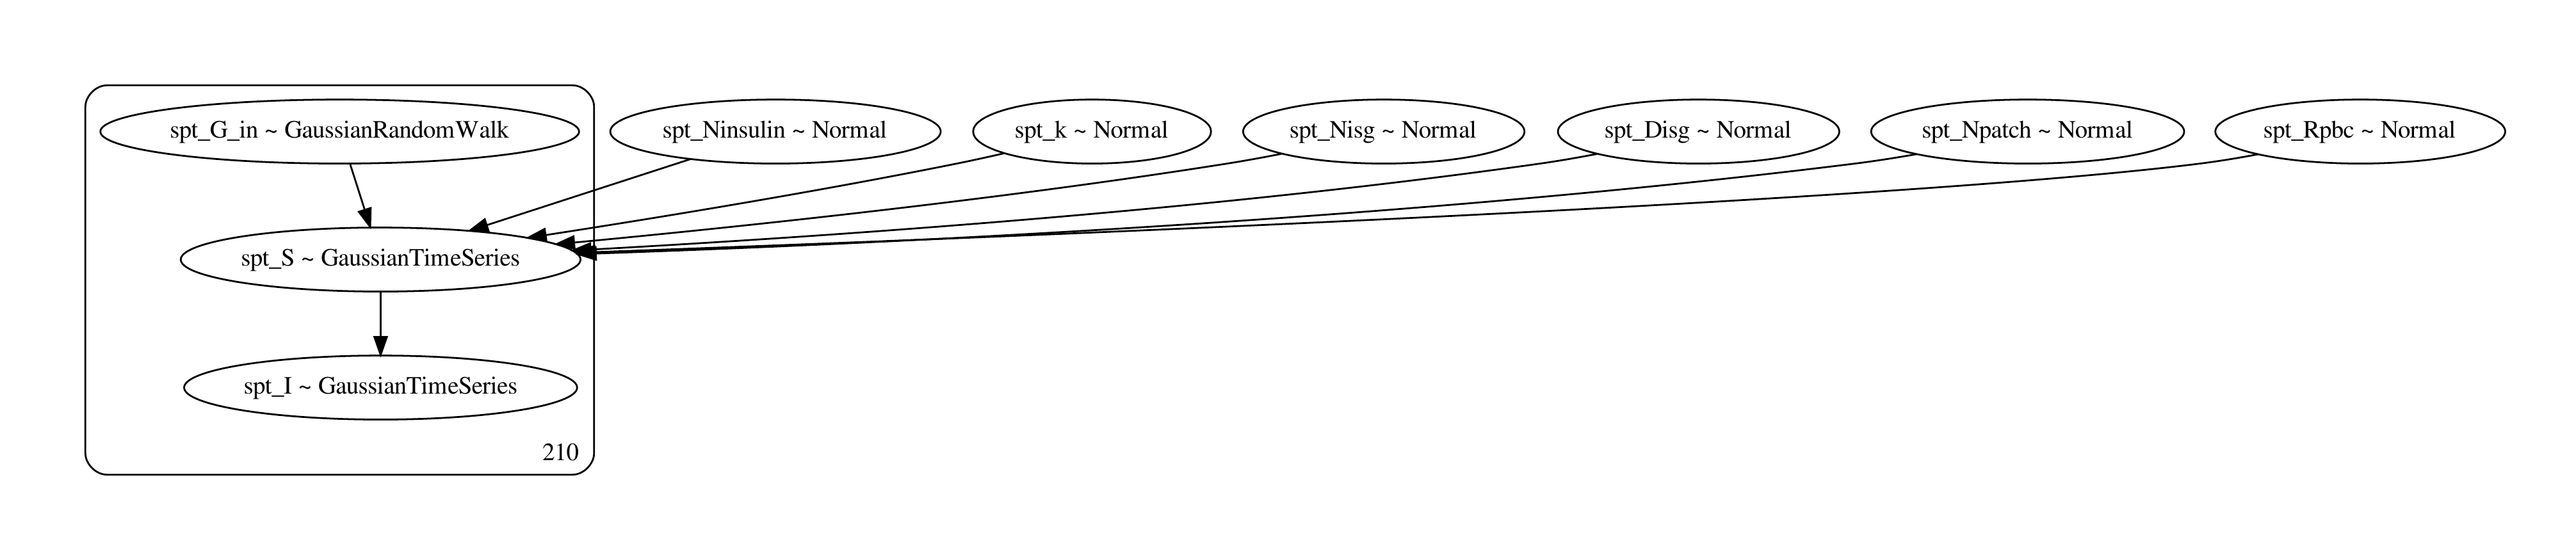

In [14]:
from mm.models import MealModel, SPTModel

meal_1 = MealModel(name="meal_normal", inputs={}, evidence={}, start={}, t=210, hpfn="default_params.json")
spt_1 = SPTModel(name="spt", inputs={}, evidence={}, start={}, t=210, hpfn="default_params.json")

print("\nMeal Model")
tu.visualize_model(meal_1, h=1000, w=800)

print("\nSPT Model")
tu.visualize_model(spt_1, h=1000, w=800)

### 3.1 Meal model
The meal-model is basically a well-known pharamcokinetic model for glucose induced postprandial insulin secretion composed of ordinary differential equations (ODE)s. You can find further details in [this paper](https://ieeexplore.ieee.org/document/4303268). We modified parts of the model so that you can think about it as a simulator that takes as input a concentration profile of ingested glucose (Gintake) and its derivative (DGintake) and produces the reponse concentrations of plasma glucose (G), plasma insulin (I) and insulin secretion rate (S), spatially averaged over the whole pancreas, on the timescale of mins. Two versions of the different model parameters are available in the literature: for healthy and type-2 diabetes (t2d) patients. 

### 3.2 SPT model
SPT stands for (SP)atio-(T)emporal and represents a toy demonstration of a (Brownian dynamics) particle simulator model of the intracellular insulin secretion. As advised before, this simulator is not biologically accurate.

1. The full version of the simulator itself is a much-much simplified representation of the secretion process, where insulin granules are treated as patchy particles that respond to collisions from diffusing glucose molecules, as well as harmonic forces from the cell-wall which represent coarse-grained actin filament interactions.Due to both active (harmonic actin, glucose colliding) and passive (self-diffusing) transport mechanisms, insulin granules are transported to the cell-wall where they can get secreted. Something like this:


![SPTModel](./content/spt.gif "spt model")


2. The SPT model in this example is a <strong>further simplification in terms of lengths and time-scales in that we assume that the intra-cellular glucose and insulin concentrations as well as insulin secretion rates are at comparable length and time-scales to the meal model</strong>. Relaxing this assumption will need more robust coupling strategies that mitigate the length and time-scaling issues between the characteristic time-scales of a PK/PD model (mins) and a mesoscopic particle simulation model (ps at best)


3. The length-scaling is acheived internally by treating each beta-cell as an independent secretory unit so that the total secretion from the pancreas is simply # of cells times the individual secretion.

### 3.3 Coupling the two models (with a healthy dose of meta-modeling philosophy!)
As explained before, the crucial protocol that allows one to couple two or more models represented as graphical models is the fact that putting an edge between two nodes in a graphical model may create <strong>active trails</strong> which initiate information flow between them. As shown in the figure below, these (red) edges can be between nodes belonging to different input models.

<div><img src="./content/mm_meal_spt.png" width="800"></div>

Thus, here the glucose concentration profile for the intra-cellular spt model is implemented as an "input" (see section 1.2) taken from the plasma glucose concentration profile for the meal model. Further the plasma insulin concentrations from both models are combined to produce a hybrid insulin profile (I_meta in the figure above) which carries information from both models. Why would anyone want to do such a hybrid combination, you ask? Remember, this is a toy example focused on demonstrating the information flow processes!

This also points to a very important note about the meta-modeling philsophy. <strong>It has come to our attention that a lot of you have thought about meta-modeling as gathering different pieces of information (experimental data, e.g.) and putting everything together into a [CellPack](http://www.cellpack.org/) model.</strong> While that is certainly a possible direction, our approach is agonstic to model representation. If one adopted the CellPack approach, one would be finally working in terms of particle coordinates as the over-arching representation. In fact, this is also how the [Integrative Modeling Platform (IMP)](https://integrativemodeling.org/) from Sali lab is currently organized. <strong>With meta-modeling however, we can let the models have their own representation with very different degrees of freedom. The meal model e.g. consists of only chemical concentrations while the spt model (in principle, considering the full Brownian dynamics simulator) need contain only particle coordinates. The statistical framework offered by PGMs is the representational unification magic that makes meta-modeling (in its current form) possible!</strong>

Moving on, we will create a meta-model from the (pre-built) meal and spt models and use the two couplers mentioned above. Quick note: we will pass an argument called hpfn to all model-builder functions. This stands for (h)yperprior (f)ile(n)ame. It is a json file containing all the hyperpriors (sigmas for Gaussian distributions, starting values for timeseries variables, etc). For this tutorial, a set of best-guess estimates of these quantities (meticulously curated by Liping Sun, Sali lab) have been kept in a file called "default_params.json".

In [15]:
HP_FN = "default_params.json"

@jit
def MetaModel(name="meta", t=100,
              inputs={}, evidence={}, start={}, 
              hpfn=HP_FN, mealmodel_type="normal"):
    
    # build the meal model
    mealmodel_name = "meal_%s" % mealmodel_type # normal or t2d
    meal = MealModel(name=mealmodel_name, t=t, inputs=inputs, evidence=evidence, start=start, hpfn=hpfn)
    
    # construct the coupler (a modified inputs dict for the spt model)
    # intracellular glucose ~ 50% of extracellular glucose
    spt_inputs = {"G_in": 0.5*meal.G}
    
    # build the spt model and providing the coupled input
    spt = SPTModel(name="spt", t=t, inputs=spt_inputs, evidence=evidence, start=start, hpfn=hpfn)
    
    # combine the plasma insulin (I) from meal and spt model
    # simple combination for now: just take an arithmetic average!
    # put a token low value of sigma (almost noise-less)#trace1 = pm.sample(model=m1, tune=2000, draws=int(ns/2), chains=2)
    I = pm.Normal("I", mu=0.5*(meal.I + spt.I), sigma=0.01)

Once we have defined the meta-model builder function MetaModel, we need to supply the I-E-S specifications, i.e. the Input-Evidence-Start for this system. If you remember from section 1.2, it is recommended that root nodes be always supplied data in the form of input and not evidence. I-E-S data for this tutorial is stored in files in the ./datasets directory.

<strong>```inputs```</strong>
<br></br>
The input for this meta-model is the derivative of ingested glucose concentration (DGintake = dGintake/dt) as a function of time (discretized for 420 mins with an interval dt=2 mins). Lets see what this profile looks like and load it into the ```inputs``` dict.

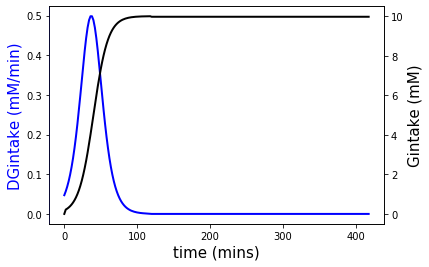

In [16]:
# timestep
dt = 2.0

# extract input data
input_data = np.loadtxt("datasets/Gintake.dat")
t_data = dt * input_data[:,0]
Gintake_data = input_data[:,2]
DGintake_data = input_data[:,1]

# load into dict
inputs = {"DGintake": DGintake_data}

# plot
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel("time (mins)", fontsize=15)
ax1.set_ylabel("DGintake (mM/min)", fontsize=15)
ax1.spines['left'].set_color('blue') ; ax1.yaxis.label.set_color('blue')
ax1.plot(t_data, DGintake_data, "b-", lw=2, label="DGintake")

ax2 = ax1.twinx()
ax2.set_ylabel("Gintake (mM)", fontsize=15)
ax2.plot(t_data, Gintake_data, "k-", lw=2);

<strong>```evidence```</strong>
<br></br>
The evidence used in this demonstration is a profile of plasma insulin concentrations for healthy and t2d cases, taken from literature. These are not exactly experimental data, rather outputs of more complex meal simulation models. Lets look at these profiles and load them into the ```evidence``` dicts.

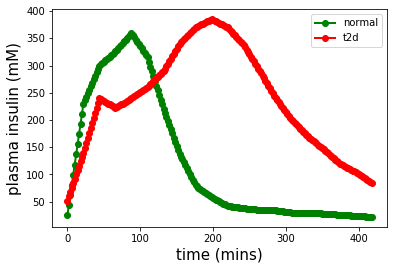

In [17]:
# extract data#trace1 = pm.sample(model=m1, tune=2000, draws=int(ns/2), chains=2)
normal_data = np.loadtxt("./datasets/glucose_insulin_normal.dat")
t2d_data = np.loadtxt("./datasets/glucose_insulin_t2d.dat")
I_normal_data = normal_data[:,2]
I_t2d_data = t2d_data[:,2]

# load into evidence dict (use full names of variable, i.e. meta-model name + "_" + variable name)
evidence_normal = {"meta_I": I_normal_data}
evidence_t2d =    {"meta_I": I_t2d_data}

# plot
plt.plot(t_data, I_normal_data, "go-", lw=2, label="normal")
plt.plot(t_data, I_t2d_data, "ro-", lw=2, label="t2d")
plt.xlabel("time (mins)", fontsize=15)
plt.ylabel("plasma insulin (mM)", fontsize=15)
plt.legend()
plt.show();

<strong>```start```</strong>
<br></br>
The starting point for time varying quantities like plasma glucose, plasma insulin and insulin secretion have already been stored in the hyper-parameter file (```default.json```, stored in the ```HP_FN``` variable). Here, we will load them into variables using a helper function.

In [18]:
from mm.utils import set_start
start_normal = {"meal_normal_State":  set_start(rvname="State", modelname="meal_normal", hpfn=HP_FN),
                "spt_S"            :  set_start(rvname="S", modelname="spt", hpfn=HP_FN),
                "spt_I"            :  set_start(rvname="I", modelname="spt", hpfn=HP_FN)}

start_t2d = {"meal_t2d_State"      :  set_start(rvname="State", modelname="meal_t2d", hpfn=HP_FN),
             "spt_S"               :  set_start(rvname="S", modelname="spt", hpfn=HP_FN),
             "spt_I"               :  set_start(rvname="I", modelname="spt", hpfn=HP_FN)}

### 3.4 Bayesian parameter inference from the meta-model
Let us train two versions of the meta-model, once with normal (i.e. healthy) parameters for the component meal model and another with t2d parameters.


Building meta-model from meal and spt models for normal data...

Building meta-model from meal and spt models for t2d data...

PGM of the normal case (double click on the PGM to zoom in)


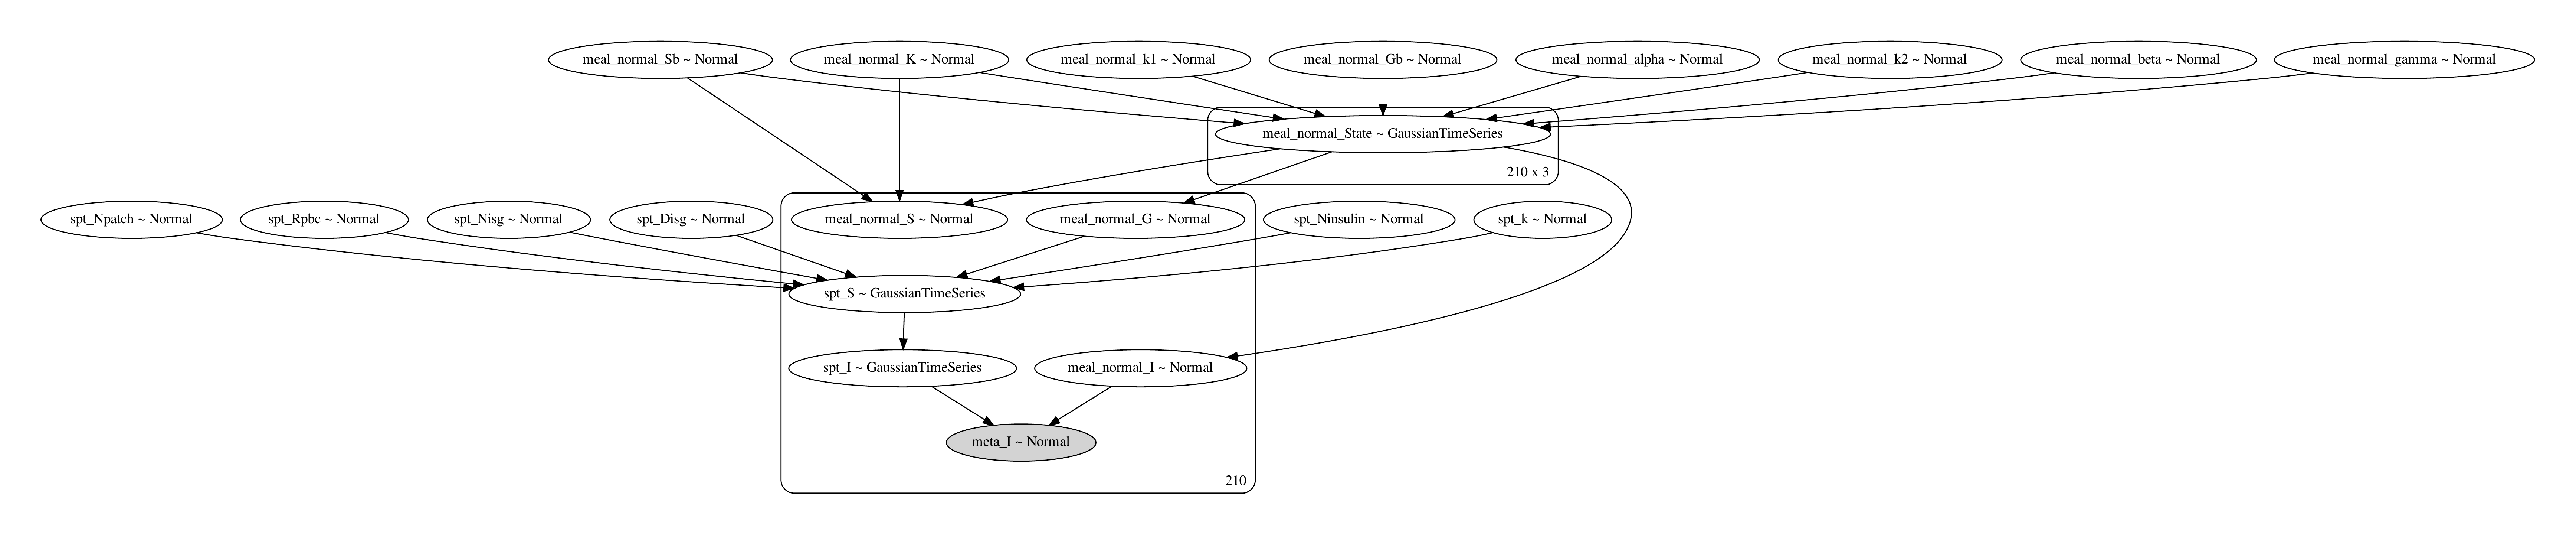

In [19]:
# number of time points
nt = len(DGintake_data)

# build the meta-models
print("\nBuilding meta-model from meal and spt models for normal data...")
mm_normal = MetaModel(name="meta", inputs=inputs, evidence=evidence_normal, start=start_normal, t=nt,
                       hpfn=HP_FN, mealmodel_type="normal")

print("\nBuilding meta-model from meal and spt models for t2d data...")
mm_t2d = MetaModel(name="meta", inputs=inputs, evidence=evidence_t2d, start=start_t2d, t=nt,
                  hpfn=HP_FN, mealmodel_type="t2d")
                         
# visualize the normal model (the t2d has the same topology, just different parameters)
print("\nPGM of the normal case (double click on the PGM to zoom in)")
tu.visualize_model(mm_normal, h=2500, w=2500)

Note how all nodes belong implicitly to the scope of their own models. Thus nodes derived from the meal model all have the prefix ```meal_normal``` (or t2d) and nodes from the spt model are prefixed with ```spt```. Only the combined plasma insulin node (to which evidence is provided, hence shaded) is in the <em>meta</em>scope and hence prefixed with the name of the meta-model ```meta```. <strong>Also just to avoid confusion the notation ```meal_normal_S ~ Normal``` means that the variable called ```S``` from the model called ```meal_normal``` has a Normal i.e. Gaussian conditional probability distribution.</strong>. 

For the rest of this section, we'll focus on three quantities: the actin network force constant $k$ from the spt model, the basal glucose level $G_b$ from the meal model and the insulin secretion rate $S$ from the meal model. First, let's collect samples from the prior distributions of ```k```, ```Gb``` and ```S```, before these get updated to their posterior distributions as a result of training.

In [20]:
k_normal_pri_samples = tu.get_prior_samples(mm_normal, "spt_k", samples=ns)
Gb_normal_pri_samples = tu.get_prior_samples(mm_normal, "meal_normal_Gb", samples=ns)
S_normal_pri_samples = tu.get_prior_samples(mm_normal, "meal_normal_S", samples=ns)

k_t2d_pri_samples = tu.get_prior_samples(mm_t2d, "spt_k", samples=ns)
Gb_t2d_pri_samples = tu.get_prior_samples(mm_t2d, "meal_t2d_Gb", samples=ns)
S_t2d_pri_samples = tu.get_prior_samples(mm_t2d, "meal_t2d_S", samples=ns)

Alrighty, its training time! Train both metamodels (normal and t2d) and collect posterior samples of $k$, $G_b$ and $S$. Training might take a while, so now is the time to go grab coffee :)

In [21]:
# train
print("\nTraining the meta-model on the normal data...")
_, trace_normal = tu.sample_posterior(mm_normal, tune=50000, samples=ns)
# co# collect prior samplesllect samples from posterior
k_normal_post_samples = trace_normal["spt_k"]
Gb_normal_post_samples = trace_normal["meal_normal_Gb"]
S_normal_post_samples = trace_normal["meal_normal_S"]

# train
print("\nTraining the meta-model on the t2d data...")
_, trace_t2d = tu.sample_posterior(mm_t2d, tune=50000, samples=ns)
# collect samples from posterior
k_t2d_post_samples = trace_t2d["spt_k"]
Gb_t2d_post_samples = trace_t2d["meal_t2d_Gb"]
S_t2d_post_samples = trace_t2d["meal_t2d_S"]

# convert samples to distributions
k_normal_pri = tu.get_distribution(k_normal_pri_samples, vartype="static", smooth=True)
Gb_normal_pri = tu.get_distribution(Gb_normal_pri_samples, vartype="static", smooth=True)
S_normal_pri, S_normal_pri_err = tu.get_distribution(S_normal_pri_samples, vartype="dynamic")
k_t2d_pri = tu.get_distribution(k_t2d_pri_samples, vartype="static", smooth=True)
Gb_t2d_pri = tu.get_distribution(Gb_t2d_pri_samples, vartype="static", smooth=True)
S_t2d_pri, S_t2d_pri_err = tu.get_distribution(S_t2d_pri_samples, vartype="dynamic")
#trace1 = pm.sample(model=m1, tune=2000, draws=int(ns/2), chains=2)
k_normal_post = tu.get_distribution(k_normal_post_samples, vartype="static", smooth=True)
Gb_normal_post = tu.get_distribution(Gb_normal_post_samples, vartype="static", smooth=True)
S_normal_post, S_normal_post_err = tu.get_distribution(S_normal_post_samples, vartype="dynamic")
k_t2d_post = tu.get_distribution(k_t2d_post_samples, vartype="static", smooth=True)
Gb_t2d_post = tu.get_distribution(Gb_t2d_post_samples, vartype="static", smooth=True)
S_t2d_post, S_t2d_post_err = tu.get_distribution(S_t2d_post_samples, vartype="dynamic")


Training the meta-model on the normal data...


Average Loss = 2.1778e+10: 100%|██████████| 50000/50000 [00:56<00:00, 885.39it/s]
Finished [100%]: Average Loss = 2.1778e+10



Training the meta-model on the t2d data...


Average Loss = 4.4755e+10: 100%|██████████| 50000/50000 [00:55<00:00, 901.66it/s]
Finished [100%]: Average Loss = 4.4754e+10


Now, lets first see the estimates of the basal glucose level $G_b$ 

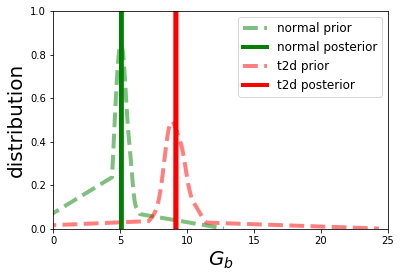

In [22]:
plt.plot(Gb_normal_pri[0], Gb_normal_pri[1], "g--", lw=4, alpha=0.5, label="normal prior")
plt.plot(Gb_normal_post[0], Gb_normal_post[1], "g-", lw=4, label="normal posterior")

plt.plot(Gb_t2d_pri[0], Gb_t2d_pri[1], "r--", lw=4, alpha=0.5, label="t2d prior")
plt.plot(Gb_t2d_post[0], Gb_t2d_post[1], "r-", lw=4, label="t2d posterior")

plt.xlim([0,25.0])
plt.ylim([0,1.0])
plt.xlabel(r"$G_b$", fontsize=20)
plt.ylabel("distribution", fontsize=20)
plt.legend(prop={"size":12});

As you can see, the posterior distributions of $G_b$ have much less (yeah those straight lines are actually super-narrow Gaussians!) noise than their priors. Bonus: basal glucose level for t2d data is higher than that for normal which makes sense! <strong>This is an important motivation for probabilistic meta-modeling. Connecting component models and allowing information flow between them allows us to refine our estimates of model parameters. </strong>

Next look at the actin network imposed force constant $k$.

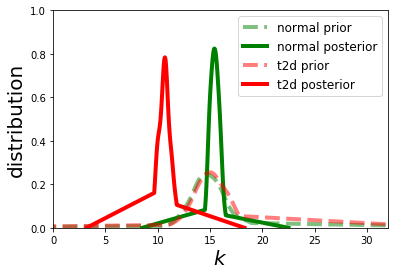

In [23]:
plt.plot(k_normal_pri[0], k_normal_pri[1], "g--", lw=4, alpha=0.5, label="normal prior")
plt.plot(k_normal_post[0], k_normal_post[1], "g-", lw=4, label="normal posterior")

plt.plot(k_t2d_pri[0], k_t2d_pri[1], "r--", lw=4, alpha=0.5, label="t2d prior")
plt.plot(k_t2d_post[0], k_t2d_post[1], "r-", lw=4, label="t2d posterior")

plt.xlim([0,32.0])
plt.ylim([0,1.0])
plt.xlabel(r"$k$", fontsize=20)
plt.ylabel(r"distribution", fontsize=20)
plt.legend(prop={"size":12});

Again, as expected, the posterior estimates of $k$ are much more confident than their prior distributions. More importantly, the priors for both normal and t2d case for $k$ are same while the posterior under t2d shifts to a lower average value. What does that mean?

1. Clearly the spt model <em>prior</em> to meta-modeling had no idea what t2d is (which is why their priors look the same), but proper information flow from the t2d paramters in the t2d meal model updates the posterior $k$ distribution.


2. <strong>This underscores another motivation for probabilistic meta-modeling, namely, a tool for determining parameters (with measurable uncertainty) which are unknown or hard to measure in experiment.</strong>


3. Indeed, if you consider what $k$ really is: in principle, it is a harmonic spring force constant that represents the average effect of the entire actin network inside the beta cell, and arguably very hard to measure or even conceive in experiment (if not impossible). In this short numerical experiment, we assumed that we know $k$ under healthy conditions (to some degree of uncertainty) and used plasma insulin data from the meta-model to estimate its value under diabetic conditions.


4. Bonus biological insight (didn't see that coming, did you?!) Lower $k$ under t2d conditions reflects slower granule trafficking to the cell membrane and thus lower overall secretion from the cell.

Finally, let's confirm point # 4 above. Look at the secretion rates:

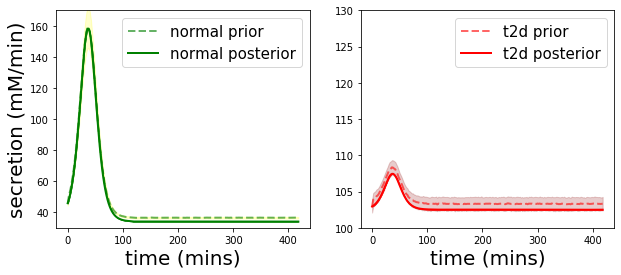

In [24]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(t_data, S_normal_pri, "g--", lw=2, alpha=0.6, label="normal prior")
ax1.fill_between(t_data, S_normal_pri-S_normal_pri_err, S_normal_pri+S_normal_pri_err, color="yellow", alpha=0.2)
ax1.plot(t_data, S_normal_post, "g-", lw=2, label="normal posterior")
ax1.fill_between(t_data, S_normal_post-S_normal_post_err, S_normal_post+S_normal_post_err, color="g", alpha=0.7)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(t_data, S_t2d_pri, "r--", lw=2, alpha=0.6, label="t2d prior")
ax2.fill_between(t_data, S_t2d_pri-S_t2d_pri_err, S_t2d_pri+S_t2d_pri_err, color="darkred", alpha=0.2)
ax2.plot(t_data, S_t2d_post, "r-", lw=2, label="t2d posterior")
ax2.fill_between(t_data, S_t2d_post-S_t2d_post_err, S_t2d_post+S_t2d_post_err, color="r", alpha=0.7)

ax1.set_xlabel("time (mins)", fontsize=20)
ax1.set_ylabel("secretion (mM/min)", fontsize=20)
ax1.set_ylim([30, 170])
ax1.legend(prop={"size": 15})

ax2.set_xlabel("time (mins)", fontsize=20)
ax2.set_ylim([100, 130])
ax2.legend(prop={"size":15});

The secretion rate under diabetic conditions indeed is about ~50% lower than under normal conditions. While that increase percentage may not be numerically accurate (remember, these are toy models!), it does serve as yet another (indirect) validation of effective information flow between the two models. As usual, the posterior profiles have much lesser uncertainty than the priors but the average values are not too different. This is expected since the meal model has t2d specific parameters, so that the priors on $S$ are <em>already quite informative to start with</em>, unlike the $k$ in the spt model.

### 3.5 Summary and outlook

Hopefully you are convinced now that:

1. Meta-modeling can refine the estimates of model parameters.


2. Meta-modeling can estimate parameters of models that are either unknown or hard to measure, given data.


3. Data used to train and estimate parameters can be provided to any node on any component model, doesn't need to be tied to the model to which the unknown parameters belong.


4. These advantages of meta-modeling are propelled by rigorous information flow protocols that are mathematically guaranteed if edges are drawn correctly between the underlying probabilistic graph representations of the different models.

The couplers designed in this short example were chosen in a way that automatically guarantees information flow according to the rules of probability theory and Bayes theorem. While these rules provide some heuristics, they don't provide absolute guidelines to design these couplers automatically. It'd be an important future direction to be able to automate the couplers such that no human decision is required to construct them.

But even before that, it is necessary to (human) design couplers that can work efficiently bridging across length and time scales when more realistic models (unlike the <em>statistical</em> toy models you saw here) that have real differences in length and time-scales are coupled. 